# Library and Packages Import

In [1]:
!pip install nltk
from nltk.corpus import stopwords

import pandas as pd
from tqdm import tqdm
import json, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import f1_score, classification_report

# Problem Statement

“ A car trading agency company in England having two main premium-class cars which are Mercedes-Benz and BMW. In a day, the customer service team have inbox emails over a thousand from senders throughout the U.K. During the expansion of branches in this year, the number of the inbox email is increasing, so the head of customer service asks Data Science team to create model in order to distinguish the email by vehicle brands and send to the incharing section directly. As company-email gathering seems confidential, so the data science team started to do web-scraping from Reddit to initiate model creation instead at first. ”

# Dataset Import & Pre-processing

## DataFrame Merging and Class Labelling

After doing webscraping, we've got 2 types of dataset, one from Mercedes-Benz sub-reddit whose data gathered from 2012 to 2023, and another one is from BMW sub-reddit whose data gathered from 2010 to 2018. At first each two datasets have more over than 28,000 observations then we dropped the observations whose text, a post content, contains "[removed]","[deleted]" and nothing ( null ), so remaining observations became around 6,500 observation for each datasets which are slight balanced in term of number of vehicle types.

In [2]:
# Import Dataset after sub-reddit web scrapping

benz= pd.read_json('data/mercedes_benz.json').drop_duplicates()
bmw = pd.read_json('data/BMW.json').drop_duplicates() 

In [3]:
# Identify the vehicle types 

benz['class'] = 0
bmw['class'] = 1

In [4]:
# Merging the two DataFrame together

df = pd.concat([benz,bmw],ignore_index = True,sort = False)   

In [5]:
# drop posts whose texts containing '[removed]','[deleted]','',None,np.NaN

values = ['[removed]','[deleted]','',None,np.NaN]

df = df[df.text.isin(values) == False]

df.reset_index(inplace=True)

In [6]:
# Seeing the output after data cleansing

df.head()

,index,vote,title,text,date,class
0,37,4,The trunk to my dads Mercedes Benz CLK 320 wil...,http://imageshack.us/photo/my-images/204/p1090...,2012-04-29,0
1,47,2,Would you buy a 128i over a c250?,Im a bmw fanboy but that merc looks so good an...,2012-06-23,0
2,48,0,"austin, need reddit's help! 1990 190e",trying to replace the ignition cyclinder have ...,2012-06-24,0
3,53,4,Option on a seventies W114 220D,Hello Mercedes-Benz enthusiasts. My neighbor i...,2012-06-28,0
4,60,6,My 2001 CLK55 AMG,A couple of pics of my 2001 CLK55 AMG. Sorry f...,2012-07-10,0


In [7]:
# Dropping the irrelevant columns

df = df.drop(['vote','date','index'], axis=1)

In [8]:
# Concating the title and text

df['post'] = df['title']+" "+df['text']

In [9]:
# Creating post length columns to see the number of words in each observation

df['post_length'] = df['post'].str.split().str.len()

In [10]:
df.head()

,title,text,class,post,post_length
0,The trunk to my dads Mercedes Benz CLK 320 wil...,http://imageshack.us/photo/my-images/204/p1090...,0,The trunk to my dads Mercedes Benz CLK 320 wil...,83
1,Would you buy a 128i over a c250?,Im a bmw fanboy but that merc looks so good an...,0,Would you buy a 128i over a c250? Im a bmw fan...,43
2,"austin, need reddit's help! 1990 190e",trying to replace the ignition cyclinder have ...,0,"austin, need reddit's help! 1990 190e trying t...",30
3,Option on a seventies W114 220D,Hello Mercedes-Benz enthusiasts. My neighbor i...,0,Option on a seventies W114 220D Hello Mercedes...,89
4,My 2001 CLK55 AMG,A couple of pics of my 2001 CLK55 AMG. Sorry f...,0,My 2001 CLK55 AMG A couple of pics of my 2001 ...,38


## EDA

We're kind of getting the slightly balanced dataset, 13,030 observations, whose 52% is from Mercedes-Benz sub-reddit and the other 48% are from BMW.

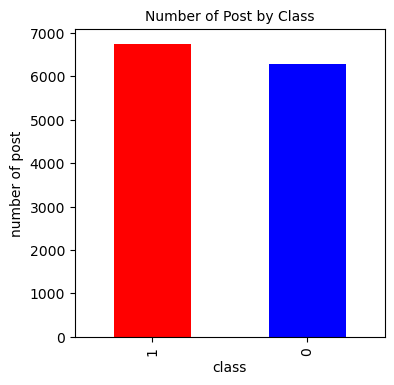

In [11]:
plt.figure(figsize = (4, 4))

df['class'].value_counts().plot(kind = 'bar',color=['red','blue'], grid = False);
plt.xlabel('class')
plt.ylabel('number of post');
plt.title("Number of Post by Class", fontsize = 10);

When we count the number of words in a post ( Title and post's content ), BMW seems to have greater number of words rather than that of Mercedes Benz. Anyways both distribution are right-skewed.
> Mean of number of words in Mercedes-Benz post : 88 words

> Mean of number of words in Mercedes-Benz post : 105 words

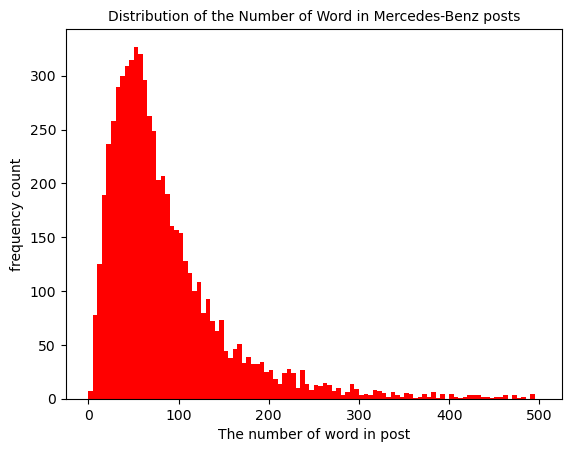

In [12]:
# Seeing the number of words distribution in Mercedes-Benz posts

plt.hist(df['post_length'][df['class']==0],bins=100,range=(0,500),color='red')
plt.xlabel('The number of word in post')
plt.ylabel('frequency count')
plt.title("Distribution of the Number of Word in Mercedes-Benz posts", fontsize = 10);

In [13]:
df['post_length'][df['class']==0].mean()

87.58294820717131

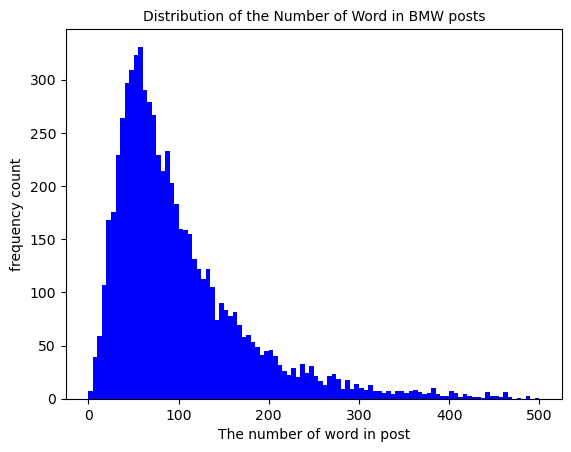

In [14]:
# Seeing the number of words distribution in BMW posts

plt.hist(df['post_length'][df['class']==1],bins=100,range=(0,500),color='blue')
plt.xlabel('The number of word in post')
plt.ylabel('frequency count')
plt.title("Distribution of the Number of Word in BMW posts", fontsize = 10);

In [15]:
df['post_length'][df['class']==1].mean()

105.43360473723168

In [16]:
# Updating English stop words

updated_stopwords  = ['BMW','Mercedes-Benz','Benz','bmw','Mercedes Benz','Mercedes','http','benz','mercedes','MB','mb']

for i in stopwords.words('english'):
    updated_stopwords.append(i)

By seeing the Top 20 common words for each vehicle types, 'class', 'amg', 'engine' are samples of most common words for Mercedes-Benz  while 'm3', 'want', 'guys' are samples of most common words for BMW. Anyways for both vehicle types are kind of having the same top common words.

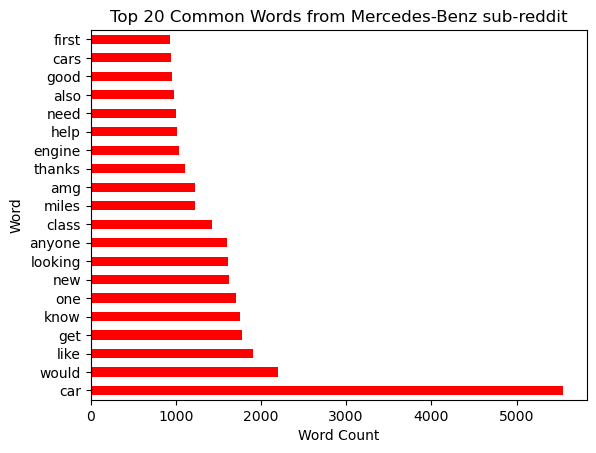

In [17]:
# Seeing what are top common words in Mercedes-Benz

df_post_benz = df['post'][df['class']==0]

cvec_2 = CountVectorizer(max_features=1000,stop_words= updated_stopwords)

X_cvec_benz = cvec_2.fit_transform(df_post_benz)

X_cvec_df_benz = pd.DataFrame(X_cvec_benz.todense(), columns = cvec_2.get_feature_names_out())

X_cvec_df_benz.sum().sort_values(ascending=False).head(20).plot(kind='barh',color='red');
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.title("Top 20 Common Words from Mercedes-Benz sub-reddit");

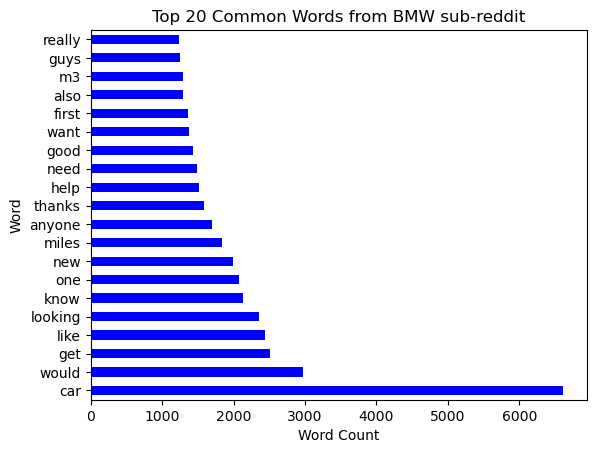

In [18]:
# Seeing what are top common words in BMW

df_post_bmw = df['post'][df['class']==1]

X_cvec_bmw = cvec_2.fit_transform(df_post_bmw)

X_cvec_df_bmw = pd.DataFrame(X_cvec_bmw.todense(), columns = cvec_2.get_feature_names_out())

X_cvec_df_bmw.sum().sort_values(ascending=False).head(20).plot(kind='barh',color='blue');
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.title("Top 20 Common Words from BMW sub-reddit");

# Modeling

In [19]:
# define feature(X) and target variable(y)

X = df[['post']]
y = df['class'] 

In [20]:
#Spliting train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [21]:
# Instantiate CountVectorizer and fit to training set

cvec = CountVectorizer(max_features=1000,stop_words= updated_stopwords)

X_train_cvec = cvec.fit_transform(X_train['post'])

X_train_cvec_df = pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names_out())


In [22]:
# Transform our testing data with the already-fit CountVectorizer.

X_test_cvec = cvec.transform(X_test['post'])
X_test_cvec_df = pd.DataFrame(X_test_cvec.todense(),columns=cvec.get_feature_names_out())

## Model 1 : Naive Bayes

### Model Training

In [23]:
nb = MultinomialNB(class_prior=[0.5,0.5])

In [24]:
nb.fit(X_train_cvec, y_train)

MultinomialNB(class_prior=[0.5, 0.5])

In [25]:
# Generate the predictions

predictions = nb.predict(X_test_cvec)

### Model Evaluation

In [26]:
# Score the model on the training set.

nb.score(X_train_cvec,y_train)

0.8725951698731068

In [27]:
# Score the model on the testing set.

nb.score(X_test_cvec,y_test)

0.8689379987722529

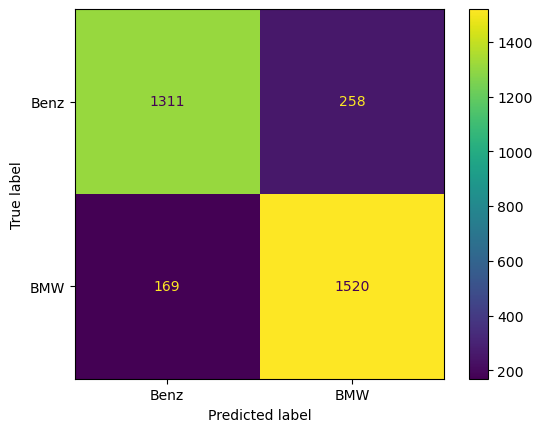

In [28]:
# ploting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,nb.predict(X_test_cvec)),display_labels = ['Benz','BMW'])
disp.plot();

In [29]:
print(classification_report(y_test,nb.predict(X_test_cvec)))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1569
           1       0.85      0.90      0.88      1689

    accuracy                           0.87      3258
   macro avg       0.87      0.87      0.87      3258
weighted avg       0.87      0.87      0.87      3258



### Error Analysis

In [30]:
# Comparing the actual class and the incorrectly predicted class by Naive Bayes Model

result_nb = pd.DataFrame({'post':X_test['post'],'actual_class':y_test, 'predicted_class':nb.predict(X_test_cvec)})
missprediction_nb = result_nb[result_nb['actual_class']!=result_nb['predicted_class']]
missprediction_nb.head()

,post,actual_class,predicted_class
1668,Looking to buy a 380/450SL (R107). Things to l...,0,1
3495,"Where is this oil coming from? Hey folks, I bo...",0,1
6335,Where do you buy your OEM and aftermarket BMW ...,1,0
9315,Looking to buy a BMW aw a 2006 BMW 325 i for 8...,1,0
2568,E63S maintenance cost So I currently have a m4...,0,1


In [31]:
# save as csv file
missprediction_nb.to_csv('error extraction/missprediction_naive_bayes.csv', index=False)

## Model 2 : Random Forest

### Model Training

In [32]:
rf = RandomForestClassifier()

In [33]:
rf_params  ={'n_estimators':[50,100,150,200],
            'max_depth':[None,2,3,4,5,6]}

In [34]:
grid = GridSearchCV(rf,param_grid = rf_params,cv=5)

In [35]:
grid.fit(X_train_cvec,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6],
                         'n_estimators': [50, 100, 150, 200]})

In [36]:
grid.best_score_ # Cross Validation Score

0.8699345299955237

In [37]:
grid.best_params_

{'max_depth': None, 'n_estimators': 200}

### Model Evaluation

In [38]:
grid.score(X_train_cvec,y_train) # Train Accuracy

0.9997953336062219

In [39]:
grid.score(X_test_cvec,y_test) # Test Accuracy 

0.874462860650706

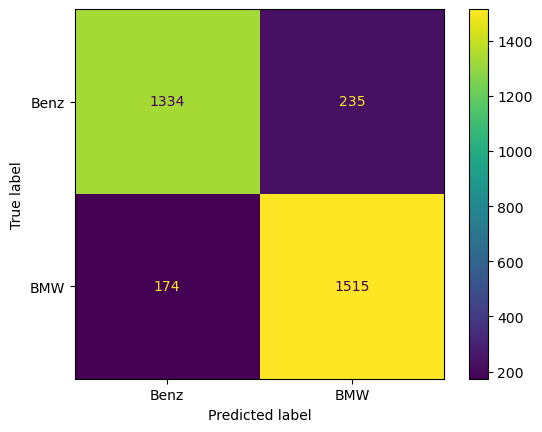

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,grid.predict(X_test_cvec)),display_labels = ['Benz','BMW'])
disp.plot();

In [41]:
print(classification_report(y_test,grid.predict(X_test_cvec)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1569
           1       0.87      0.90      0.88      1689

    accuracy                           0.87      3258
   macro avg       0.88      0.87      0.87      3258
weighted avg       0.87      0.87      0.87      3258



### Error Analysis

In [42]:
# Comparing the actual class and the incorrectly predicted class by Random Forests

result_rf = pd.DataFrame({'post':X_test['post'],'actual_class':y_test, 'predicted_class':grid.predict(X_test_cvec)})
missprediction_rf = result_rf[result_rf['actual_class']!=result_rf['predicted_class']]
missprediction_rf.head()

,post,actual_class,predicted_class
1668,Looking to buy a 380/450SL (R107). Things to l...,0,1
7283,Do you think I could find a 1996-1999 328 (mil...,1,0
6335,Where do you buy your OEM and aftermarket BMW ...,1,0
9315,Looking to buy a BMW aw a 2006 BMW 325 i for 8...,1,0
2568,E63S maintenance cost So I currently have a m4...,0,1


In [43]:
# save as csv file
missprediction_rf.to_csv('error extraction/missprediction_random_forest.csv', index=False)

# Conclusion and Recommendation

The Data Science team recommended Model 2 : Random Forest with GridSearchCV to customer service team which has an approximately accuracy 88% on unseen data set. If the head of customer service accept with this model, the customer service team need to verify for the other 12% of the incoming emails.